# Face recognition siamese model

## Imports

In [ ]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import random_split

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, RandomHorizontalFlip, Resize

from torchdata.datapipes.iter import Zipper, IterableWrapper

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Data pre-processing

In [ ]:
PEOPLE = ('divy', 'matt', 'arnav')

In [ ]:
img_transforms = Compose([
    RandomHorizontalFlip(),
    ToTensor(),
    Resize((105, 105)),
])

# maps: "person" -> datasets.ImageFolder
full_dataset = {}

for person in PEOPLE:
    full_dataset[person] = datasets.ImageFolder(root=os.path.join('data', person), transform=img_transforms)

dataset = [img_paths, labels]

Labels:
- anchor = 0
- positive = 1
- negative = 2

In [ ]:
# TODO: use a loop to iterate over all the profiles

# maps "person" -> array of booleans of where the anchor, positive, and negative images are in the dataset
is_anchor = {}
is_positive = {}
is_negative = {}

for person in PEOPLE:
    is_anchor[person] = torch.tensor(full_dataset[person].targets) == 0
    is_negative[person] = torch.tensor(full_dataset[person].targets) == 1
    is_positive[person] = torch.tensor(full_dataset[person].targets) == 2

# extract the anchor, positive, and negative img indices
anchor_indices = {}
positive_indices = {}
negative_indices = {}

for person in PEOPLE:
    anchor_indices[person] = is_anchor[person].nonzero().flatten()
    negative_indices[person] = is_negative[person].nonzero().flatten()
    positive_indices[person] = is_positive[person].nonzero().flatten()

# create the anchor, positive, and negative datasets
anchor_dataset = {}
positive_dataset = {}
negative_dataset = {}

for person in PEOPLE:
    anchor_dataset[person] = Subset(full_dataset[person], anchor_indices[person])
    negative_dataset[person] = Subset(full_dataset[person], negative_indices[person])
    positive_dataset[person] = Subset(full_dataset[person], positive_indices[person])

Now, the datasets are [(img, label), (img, label), (img, label), ...]. We need them to be [img, img, img, ...] only, no label needed since they are already split by label.

In [ ]:
# WARNING: this takes about 2 minutes to run, please only run it once
for person in PEOPLE:
    anchor_dataset[person] = [sublist[0] for sublist in list(anchor_dataset[person])]
    negative_dataset[person] = [sublist[0] for sublist in list(negative_dataset[person])]
    positive_dataset[person] = [sublist[0] for sublist in list(positive_dataset[person])]

#### Visualizing raw datasets (testing only)

In [ ]:
# Uncomment when testing
# ds = positive_dataset['divy']
# total = 100 # number of images to show

# figure, axis = plt.subplots(total // 10, 10, figsize=(16, total // 5))

# for i in range(total):
#     row = i // 10
#     col = i % 10 
#     axis[row, col].imshow(ds[i].squeeze(0).permute(1, 2, 0))
#     axis[row, col].set_xticks([])
#     axis[row, col].set_yticks([])

# plt.show()

#### Zip anchor, positive, and negative datasets together

In [ ]:
zipped_pos_dataset = {}
zipped_neg_dataset = {}

for person in PEOPLE:
    zipped_pos_dataset[person] = Zipper(IterableWrapper(anchor_dataset[person]), IterableWrapper(positive_dataset[person]), IterableWrapper(torch.ones(len(anchor_dataset[person]))))
    zipped_neg_dataset[person] = Zipper(IterableWrapper(anchor_dataset[person]), IterableWrapper(negative_dataset[person]), IterableWrapper(torch.zeros(len(anchor_dataset[person]))))

    zipped_pos_dataset[person] = list(zipped_pos_dataset[person])
    zipped_neg_dataset[person] = list(zipped_neg_dataset[person])

Now the `zipped_pos_dataset` has the format: `[(anchor, positive, 1), (anchor, positive, 1), ...]`. Here the 1 is the label of the pair, which signifies that the image is positive, meaning from the same person as anchor. So the `zipped_neg_dataset` has 0s instead of 1s and negative images instead of positive.

In [ ]:
# Combine the positive and negative datasets and shuffle them
final_dataset = []
for person in PEOPLE:
    final_dataset += zipped_pos_dataset[person] + zipped_neg_dataset[person]

np.random.shuffle(final_dataset)

#### Visulizing final datasets (testing only)

In [ ]:
# Uncomment when testing
# ds = final_dataset
# total = 100 # number of images to show

# figure, axis = plt.subplots(total // 10, 10, figsize=(16, total // 5))

# for i in range(total):
#     row = i // 10
#     col = i % 10 
#     axis[row, col].imshow(ds[i][1].squeeze(0).permute(1, 2, 0))
#     axis[row, col].set_xticks([])
#     axis[row, col].set_yticks([])

# plt.show()

## Data loading

In [ ]:
batch_size = 16

# split between training and testing 80-20
train_set, test_set = random_split(final_dataset, [int(len(final_dataset) * 0.8), len(final_dataset) - int(len(final_dataset) * 0.8)])
train_dataloader : DataLoader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader : DataLoader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

len(dataloader) = number of batches = total imgs in final_dataset / batch_size

Data is organized inside `dataloader` as follows: [anchors, pos/neg imgs, label]
- img is of shape [3, 224, 224], since there is _batch_size_ (currently 64) images in a batch, the shape of anc/pos/neg imgs is [64, 3, 224, 224]
- label is either 0 or 1: 0 for negative, 1 for positive

Note: run the next block to confirm

In [ ]:
first_batch = train_dataloader._get_iterator().__next__()

# N = batch size, C = color channels, H = height, W = width
print("Shape of data [N, C, H, W]: ", first_batch[0].shape)
print("Shape of labels: ", first_batch[2].shape, first_batch[1].dtype)

#### Visualizing the data for debugging

In [ ]:
# first image is at first_batch[0][0]
# batch[i][j] where i is type (0=anchor vs 1=pos/neg) and j is image index in the batch

# Uncomment line below when testing
# plt.imshow(first_batch[0][1].permute(1, 2, 0))

# How to access different batches:
#     it = train_dataloader._get_iterator()
#     first_batch = it._next_data()
#     second_second = it._next_data()

## Model

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

### Embedding layer

In [ ]:
class EmbeddingNetwork(nn.Module):
    def __init__(self):
        super(EmbeddingNetwork, self).__init__()
        
        # layers
        # first layer: 3 input channels, 64 output channels
        self.l1 = nn.Conv2d(3, 64, 10, padding=1)
        self.a1 = nn.ReLU()
        self.p1 = nn.MaxPool2d(2)
        
        # second layer: 64 input channels, 128 output channels
        self.l2 = nn.Conv2d(64, 128, 7, padding=1)
        self.a2 = nn.ReLU()
        self.p2 = nn.MaxPool2d(2)
        
        # third layer: 128 input channels, 128 output channels
        self.l3 = nn.Conv2d(128, 128, 4, padding=1)
        self.a3 = nn.ReLU()
        self.p3 = nn.MaxPool2d(2)
        
        # fourth layer: 128 input channels, 256 output channels
        self.l4 = nn.Conv2d(128, 256, 4, padding=1)
        self.a4 = nn.ReLU()
        self.p4 = nn.Flatten()

    def forward(self, x):
        """Pass the input tensor through the embeddding network.

        Args:
            x: input tensor, 3 channels, 105x105 pixels

        Returns:
            torch.Tensor: output tensor, 4096 channels
        """
        x = self.l1(x)
        x = self.a1(x)
        x = self.p1(x)
        
        x = self.l2(x)
        x = self.a2(x)
        x = self.p2(x)
        
        x = self.l3(x)
        x = self.a3(x)
        x = self.p3(x)
        
        x = self.l4(x)
        x = self.a4(x)
        x = self.p4(x)
        
        return x

### Siamese network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # embedding layer
        self.embedding_layer = EmbeddingNetwork()
        
        # fully connected classification layer
        # 2 classes: 0 (negative) and 1 (positive)
        self.feature_vector = nn.Linear(20736, 4096)
        self.classification_layer = nn.Linear(4096, 2)
        
    def forward(self, anchor, db_image):
        """Pass the input tensor through the siamese network.

        Args:
            anchor (torch.Tensor): input image (from webcam), 3 channels, 105x105 pixels
            db_image (torch.Tensor): target image (from database), 3 channels, 105x105 pixels

        Returns:
            torch.Tensor: output tensor, 1 channel
        """
        # pass through embedding layer
        anchor = self.embedding_layer(anchor)
        db_image = self.embedding_layer(db_image)
        
        # calculate the absolute difference between the two embeddings
        dist = torch.abs(anchor - db_image)
        
        # pass through fully connected classification layer
        x = self.feature_vector(dist)
        x = self.classification_layer(x)
        
        return x

### Loss and optimizer

In [ ]:
model = SiameseNetwork().to(device)
print(model)

In [ ]:
# using cross entropy loss function and adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

## Training & testing

### Training

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    # Get the size of the dataset
    size = len(dataloader.dataset)
    # Put the model in training mode
    model.train()
    # Loop over the dataset
    for batch, (X, Y, z) in enumerate(dataloader):
        X, Y, z = X.to(device), Y.to(device), z.to(device)
        
        z = z.type(torch.LongTensor)

        pred = model(X, Y)
        loss = loss_fn(pred, z)

        # Backpropagation
        # Disable the gradient calculation for the model parameters
        optimizer.zero_grad()
        # Compute the gradient of the loss with respect to the model parameters
        loss.backward()
        # Update the model parameters
        optimizer.step()

        # Print the loss every 3 batches
        if batch % 3 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    # Get the size of the dataset
    size = len(dataloader.dataset)
    # Get the number of batches
    num_batches = len(dataloader)
    # Put the model in evaluation mode
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # for memory efficiency when testing
        # Loop over the dataset
        for X, Y, z in dataloader:
            X, Y, z = X.to(device), Y.to(device), z.to(device)
            z = z.type(torch.LongTensor)
            pred = model(X, Y)
            test_loss += loss_fn(pred, z).item()
            # Add the output value (1 or 0) to the correct variable
            correct += (pred.argmax(1) == z).type(torch.float).sum().item()
    # Compute the average loss and accuracy
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}: -------------------------------")
    # Train the model
    train(train_dataloader, model, loss_fn, optimizer)
    # Test the model
    test(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
# Saving the model in a file, we will use it in the next cell
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

### Manual testing

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("model.pth"))

model.eval()

en = enumerate(test_dataloader)
x, y, z = en.__next__()[1]

print(len(test_dataloader.dataset)/batch_size)

for j in range(int(len(test_dataloader.dataset)/batch_size)-1):
    x, y, z = en.__next__()[1]
    for i in range(batch_size):
        with torch.no_grad():
            pred = model(x[i].unsqueeze(0), y[i].unsqueeze(0))
            predicted, actual = pred[0].argmax(0), z[0]
            # print(f'Predicted: "{predicted}", Actual: "{actual}"')

### Visualizing tests with images

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("model.pth"))

model.eval()

ds = test_dataloader.dataset

fail_counter: int = 0
pass_counter: int = 0
total = int(len(ds)) - 1 # Number of test_data points to be used
model_results = {}

for i in range(total):
    x, y, z = ds[i][0], ds[i][1], ds[i][2]
    with torch.no_grad():
        pred = model(x.unsqueeze(0), y.unsqueeze(0))
        predicted, actual = pred[0].argmax(0), z
        # print(f'Predicted: "{predicted}", Actual: "{actual}"')
        if (predicted != actual):
            fail_counter += 1
            print("Fail on", i)
        else:
            pass_counter += 1
    model_results[i] = predicted

print("===============RESULTS================")
print(f'Pass: {pass_counter}, Fail: {fail_counter}, Accuracy: {pass_counter/total * 100}')

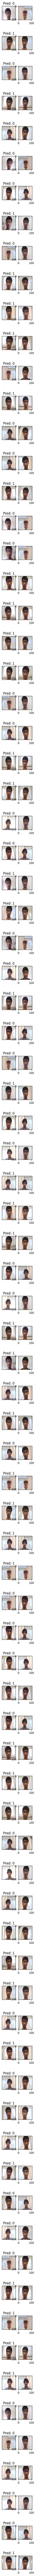

In [47]:
figure, axis = plt.subplots(total, 2, figsize=(2, total * 2))
img_idx = 1 # imgae to show: 0 = anchor, 1 = pos/neg

for i in range(total):
    row = i
    col = 0
    axis[row, col].imshow(ds[i][0].squeeze(0).permute(1, 2, 0))
    axis[row, col + 1].imshow(ds[i][1].squeeze(0).permute(1, 2, 0))
    axis[row, col].set_xticks([])
    axis[row, col].set_yticks([])
    axis[row, col].set_title(f"Pred: {model_results[i]}")

# Show the plot
plt.show()